# Variables Comúnes

In [ ]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from functools import reduce
from scipy.stats import poisson, chisquare

ultima_temporada = [
    "la_liga_temp_23_24.csv"
]

todas_temporadas = [
    "la_liga_temp_19_20.csv",
    "la_liga_temp_20_21.csv",
    "la_liga_temp_21_22.csv",
    "la_liga_temp_22_23.csv",
    "la_liga_temp_23_24.csv"
]

# Definir los buckets para el analisis
bins = [0, 0.5, 1.5, 2.5, 3.5, 4.5]
bin_labels = [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins) - 1)]

In [ ]:
file_paths = todas_temporadas

all_seasons_local = []
all_seasons = []
for file_path in file_paths:
    data = pd.read_csv(file_path)

    # Combinar datos de partidos jugados de local y visitante para cada equipo
    local_data = data[['Local', 'xG_local']].rename(columns={'Local': 'team', 'xG_local': 'xG'})
    away_data = data[['Visitante', 'xG_visitante']].rename(columns={'Visitante': 'team', 'xG_visitante': 'xG'})
    season_data = pd.concat([local_data, away_data])
    all_seasons.append(season_data)
    all_seasons_local.append(local_data)

# Nos quedamos con los equipos que jugaron en TODAS las temporadas a analizar
equipos = reduce(
    lambda teams, season: teams & set(season['team']),
    all_seasons,
    set(all_seasons[0]['team'])
)

with open("equipos.csv", mode="w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["equipos"])
    for equipo in equipos:
        writer.writerow([equipo])

combined_data = pd.concat(all_seasons)
combined_data_local = pd.concat(all_seasons_local)
combined_data = combined_data[combined_data['team'].isin(equipos)]
combined_data_local = combined_data_local[combined_data_local['team'].isin(equipos)]

combined_data.reset_index(drop=True, inplace=True)
combined_data_local.reset_index(drop=True, inplace=True)

# Ploteos distribución de expected goals

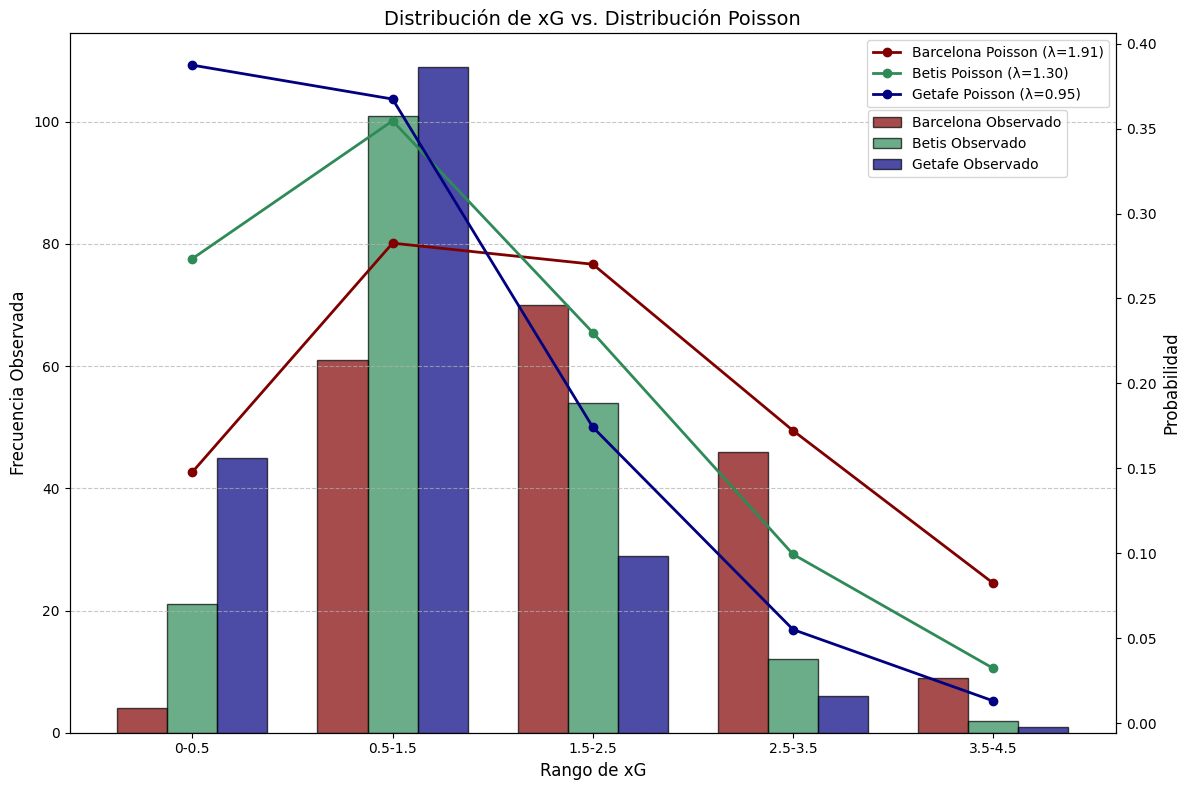

In [ ]:
# Define teams to compare
teams = ['Barcelona', 'Betis', 'Getafe']

# Define distinct colors for each team
colors = {
    'Barcelona': 'maroon',
    'Betis': 'seagreen',
    'Getafe': 'navy'
}

fig, ax1 = plt.subplots(figsize=(12, 8))
ax2 = ax1.twinx()

bar_width = 0.25  # Adjust the width so bars don’t overlap
offsets = np.linspace(-bar_width, bar_width, len(teams))  # Offsets for side-by-side bars

# Loop through teams and plot histograms & Poisson distributions
for i, team in enumerate(teams):
    team_data = combined_data[combined_data['team'] == team]['xG']
    team_matches = len(team_data)
    mean_xg = team_data.mean()

    # Histogram (Observed Frequencies)
    hist_counts, _ = np.histogram(team_data, bins=bins)

    # Adjust x positions for side-by-side bars
    bin_positions = np.arange(len(bin_labels)) + offsets[i]

    ax1.bar(bin_positions, hist_counts, width=bar_width, alpha=0.7,
            color=colors[team], edgecolor='black', label=f'{team} Observado')

    # Poisson Distribution (Expected Probabilities)
    x_values = np.arange(len(bin_labels))
    poisson_probs = poisson.pmf(x_values, mean_xg)

    ax2.plot(np.arange(len(bin_labels)), poisson_probs,
      marker='o', linestyle='-', linewidth=2, color=colors[team],
      label=f'{team} Poisson (λ={mean_xg:.2f})')


# Labels & Titles
ax1.set_xlabel("Rango de xG", fontsize=12)
ax1.set_ylabel("Frecuencia Observada", fontsize=12)
ax1.set_title("Distribución de xG vs. Distribución Poisson", fontsize=14)
ax1.set_xticks(np.arange(len(bin_labels)))  # Ensure x-ticks align correctly
ax1.set_xticklabels(bin_labels, fontsize=10)
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.legend(loc="upper right", bbox_to_anchor=(0.96,0.9))
ax2.legend(loc="upper right")
ax2.set_ylabel("Probabilidad", fontsize=12)

plt.tight_layout()
plt.savefig('distribucion_xG.png')
plt.show()


xG mean: 1.5432456140350879
xG deviation: 0.8329359263733518


<ipython-input-5-c3473c503f54>:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(loc="upper right", bbox_to_anchor=(0.96,0.9))


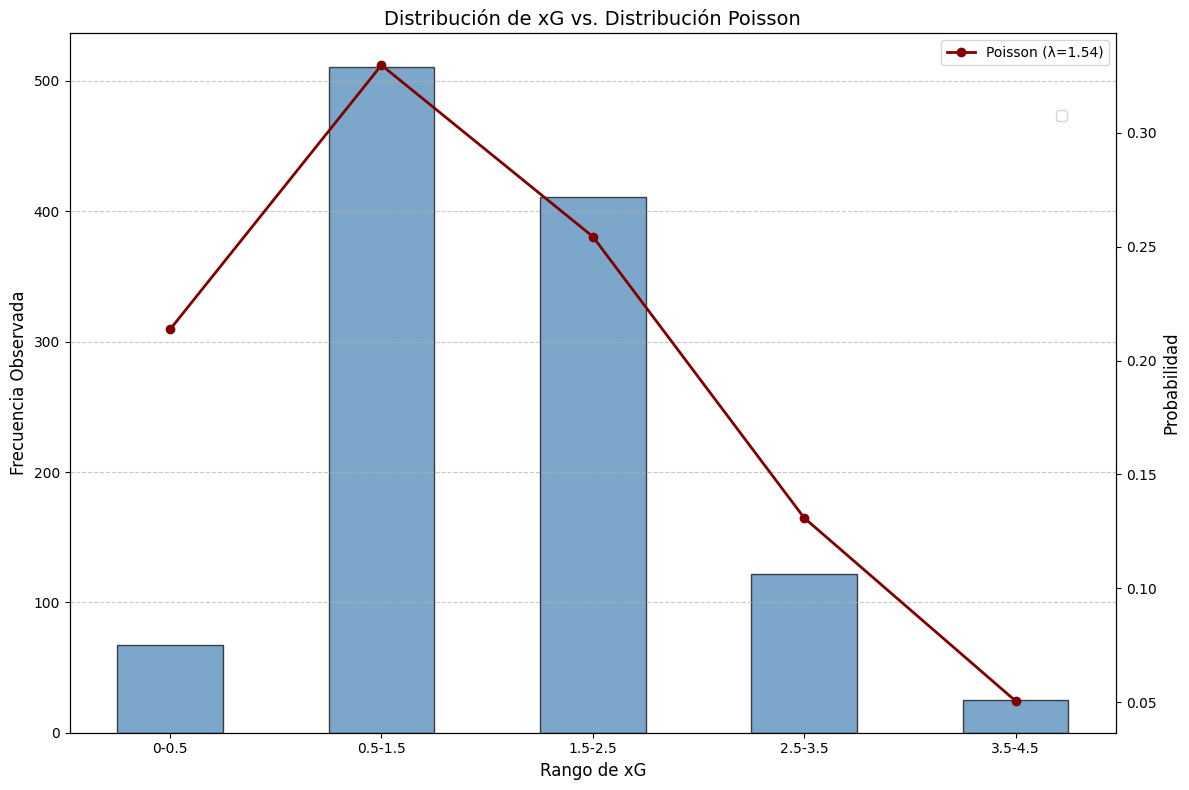

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 8))
ax2 = ax1.twinx()

bar_width = 0.50 # Adjust the width so bars don’t overlap
bin_positions = np.arange(len(bin_labels))

# plot histogram & Poisson distributions
xG_data = combined_data_local['xG']
mean_xg = xG_data.mean() # mean xG for local teams
std_xG = xG_data.std()

print('xG mean: ' + str(mean_xg))
print('xG deviation: ' + str(std_xG))

# Histogram (Observed Frequencies)
hist_counts, _ = np.histogram(xG_data, bins=bins)

ax1.bar(bin_positions, hist_counts, width=bar_width, alpha=0.7, color='steelblue', edgecolor='black')

# Poisson Distribution (Expected Probabilities)
x_values = np.arange(len(bin_labels))
poisson_probs = poisson.pmf(x_values, mean_xg)

ax2.plot(np.arange(len(bin_labels)), poisson_probs,
  marker='o', linestyle='-', linewidth=2, color='maroon',
  label=f'Poisson (λ={mean_xg:.2f})')


# Labels & Titles
ax1.set_xlabel("Rango de xG", fontsize=12)
ax1.set_ylabel("Frecuencia Observada", fontsize=12)
ax1.set_title("Distribución de xG vs. Distribución Poisson", fontsize=14)
ax1.set_xticks(np.arange(len(bin_labels)))  # Ensure x-ticks align correctly
ax1.set_xticklabels(bin_labels, fontsize=10)
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.legend(loc="upper right", bbox_to_anchor=(0.96,0.9))
ax2.legend(loc="upper right")
ax2.set_ylabel("Probabilidad", fontsize=12)

plt.tight_layout()
plt.savefig('distribucion_xG_local.png')
plt.show()

# Prueba de Chi cuadrado vs distribución poisson

In [ ]:
teams = combined_data['team'].unique()
results = []
x_values = np.arange(0, 5, 1)

for team in teams:
    team_data = combined_data[combined_data['team'] == team]['xG']
    team_data_binned = pd.cut(team_data, bins=bins, labels=bin_labels, right=False)

    # Agrupar los xG por bucket
    observed_frequencies = team_data_binned.value_counts(sort=False).values

    # Obtener la media (λ) para la distribución de poisson
    lambda_hat = team_data.mean()

    # Calcular las frecuencias esperadas dada una distribucion de poisson con parametro λ
    expected_frequencies = [
      len(team_data) * (poisson.cdf(bins[i + 1], lambda_hat) - poisson.cdf(bins[i], lambda_hat))
      for i in range(len(bin_labels))
    ]

    # poisson_probs = poisson.pmf(x_values, lambda_hat)

    # expected_frequencies = [
    #  len(team_data) * (poisson_probs[i])
    #  for i in range(len(bin_labels))
    #]

    print(observed_frequencies)
    print(expected_frequencies)

    # Prueba de chi cuadrado
    chi2_stat, p_value = chisquare(f_obs=observed_frequencies, f_exp=expected_frequencies)

    results.append({
        'team': team,
        'lambda_hat': lambda_hat,
        'chi2_stat': chi2_stat,
        'p_value': p_value,
        'is_poisson': p_value > 0.05  # Aceptar la hipotesis nula si p > 0.05
    })

results_df = pd.DataFrame(results)
print(results_df)


[81 61  9  1  0]
[55.91708027083622, 27.829783700583988, 9.233873407671833, 2.297837247665708, 0.45745102048924036]


ValueError: For each axis slice, the sum of the observed frequencies must agree with the sum of the expected frequencies to a relative tolerance of 1e-08, but the percent differences are:
0.5876990816400255